In [12]:
%matplotlib inline

# Introduction

This notebook tests the new feature "Recobundles" from https://github.com/nipy/dipy/pull/1443#issuecomment-373049087

https://www.sciencedirect.com/science/article/pii/S1053811917305839

## Take 2: Pre-Registration

Added pre-registration to tailor the template to the dataset, and performance improved greatly. The recognized bundles tend to include extra sub-bundles similar to the template. Enforcing single-template membership for each streamline would probably help with this. Refinement of the template would also improve performance; this was using a manually-cleaned single subject as a template. Note: Prisma cases were corrected for susceptibility distortion. The template was made from a case scanned on the Prisma.

Notes from visual inspection (N=1 test brain against N=1 template brain on N=2 scanners):

IFOF
- very good

ILF
- pretty good; a few sub-bundles to clean up (endpoints would help)

UNCINATE
- Some extra sub-bundles, especially short/high turning angle tracks. Frontal targets may help
- There's a debate on what sub-bundles should be included in uncinate... maybe more specific template separating the different components would be helpful
    
ARCUATE/SLF COMPLEX (includes 3 tracks: Arcuate, SLF ip, SLF tp)
- Some mixing SLFip vs. Arcuate vs. SLFtp, but reasonably good performance
    - Differential templates? (enforce single-template membership)
    - Some truncated Arcuate streamlines are included in SLF-ip; enforcing cortical termination may help
- Arcuate low specificity
    - Some Aslant streamlines in Arcuate
    - Some SLF-ip streamlines in Arcuate
    - differential template may help
    - Enforce single-bundle membership
- SLF ip template had a lot of different sub-bundles... other subjects have much more devined models of SLFII and SLFIII... changing the template to one of those may help considerably
- SLF tp has a lot of other sub-bundles; perhaps a differential template?

ASLANT
- pretty good 
- There is an extra branch apparent on the coronal view
- Greater anterior-posterior extent of bundle
    - Differential templates may help to select a particular segment of this larger bundle



NOTES FROM @Garyfallidis

- Pre-registration is assumed

- Pruning threshold most important

- Use multiple streamline distances

# Import/Define Functions

In [189]:
import os
from glob import glob

import nibabel as nib
import numpy as np

from dipy.tracking.distances import bundles_distances_mam
from dipy.tracking.streamline import Streamlines
from dipy.segment.bundles import RecoBundles
from dipy.segment.clustering import qbx_with_merge
from dipy.data import get_data
from dipy.align.streamlinear import whole_brain_slr, slr_with_qb, transform_streamlines


from IPython.display import display, HTML, Image

In [14]:
def make_html(path_list):
    myhtml = ''
    for path in path_list:
        myhtml+='<img src="{}" style="float: left; width: 40%; margin-right: 1%; margin-bottom: 0.5em;"/>'.format(path)
    return myhtml

In [15]:
from dipy.viz import window, actor

def genren(sls, sls2=None, niidata=None, roi1=None, roi2=None, aff=None, putpath=None, show=False, orient=True, colors=[(1,1,1)]):
    
    renderer = window.Renderer()
    
    if len(colors)>1:
        stream_actor = actor.line(sls, colors=colors[1])
    else:
        stream_actor=actor.line(sls)
        
    renderer.add(stream_actor)
    
    if sls2 is not None:
        stream_actor2 = actor.line(sls2, colors=colors[0])
        renderer.add(stream_actor2)
    
    if roi1 is not None and roi2 is not None:
        
        contour_actor1 = actor.contour_from_roi(roi1, affine=aff, color=(1., 1., 0.),
                                          opacity=0.5)
        contour_actor2 = actor.contour_from_roi(roi2, affine=aff, color=(1., 0., 0.),
                                          opacity=0.5)
        renderer.add(contour_actor1)
        renderer.add(contour_actor2)
        
    
    if niidata is not None:
        slice_actor = actor.slicer(niidata, affine=aff)
        renderer.add(slice_actor)

    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #                    focal_point=(113.30, 128.31, 76.56),
    #                    view_up=(0.18, 0.00, 0.98))

    if orient:
        axes_actor = actor.axes(scale=(10, 10, 10), colorx=(1, 0, 0), colory=(0, 1, 0), colorz=(0, 0, 1), opacity=1)
        #Create an actor with the coordinate’s system axes where red = x, green = y, blue = z.
        renderer.add(axes_actor)

    if show:
        window.show(renderer, size=(600, 600), reset_camera=False)
    if putpath is not None:
        window.record(renderer, out_path=putpath, size=(600, 600))
    del renderer
    return putpath

In [211]:
def run_rb(templatesls, bucketosls, cluster_map=None):
    # try pruning thresh 10 if not specific drop to 5
    if cluster_map is None:
        cluster_map = qbx_with_merge(bucketosls, thresholds=[40, 25, 20, 10])
    else:
        print("Loading provided cluster map")

    rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=5)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=5.,
                                                         reduction_thr=10, pruning_thr=5)
    '''rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=10)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=1.)'''
    #D = bundles_distances_mam(templatesls, recognized)
    
    return recognized, cluster_map

In [205]:
def rough_reg(sub_fixed, temp_moving):
    #template moves to the subject space
    #qb_thr=5 errored
    moved, transform, qb_centroids1, qb_centroids2 = whole_brain_slr(sub_fixed, temp_moving, 
                                                                     verbose=True,
                                                                     progressive=True)
    return moved, transform, qb_centroids1, qb_centroids2

This is taking a very long time (large datasets)... there is probably a reasonable subsampling that will universally suffice... perhaps reducing the streamline dataset prior to running the quickbundles would help? (maybe a flag that is defaulted to false to specify if the user really wants all streamlines represented?)

# Find paths/load data

In [197]:
putdir = 'output_Kesh_Test_Recobundles_testing_elefsugg'
if not os.path.exists(putdir):
    os.mkdir(putdir)

In [198]:
def loadtgm_newapi(trkpath):
    trkloaded = nib.streamlines.trk.TrkFile.load(trkpath)
    hdrloaded = trkloaded.header
    tg=trkloaded.tractogram
    return tg

Whole brain from Prisma and Trio (same brain)

In [199]:
wb_prisma_path = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/Whole_Brain_bs_prob_gt40mm_good.trk'
wb_prisma_path_raw = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/Whole_Brain_bs_prob.trk'
wb_trio_path_raw = '/Users/kesshijordan/ref_data/interscan_dys/Trio/TRACKs/Whole_Brain_bs_prob.trk'

#single case gold standard
gs_prisma_path = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/'
gs_trio_path = '/Users/kesshijordan/ref_data/interscan_dys/Trio/TRACKs/'

#single case template
pathpath = '/Users/kesshijordan/paths/recobundles_template_basepath.txt'
with open(pathpath, 'r') as myfile:
    template_basepath = myfile.read().replace('\n', '').replace('\'','')

# Prisma Whole Brain Dataset from Subject

In [200]:
#Nice streamlines
#wb_prisma_tg = loadtgm_newapi(wb_prisma_path)
#wb_prisma_sls = wb_prisma_tg.streamlines

In [22]:
wb_rawprisma_tg = loadtgm_newapi(wb_prisma_path_raw)
wb_rawprisma_sls = wb_rawprisma_tg.streamlines

# Trio Whole Brain Dataset from Subject

In [23]:
wb_rawtrio_tg = loadtgm_newapi(wb_trio_path_raw)
wb_rawtrio_sls = wb_rawtrio_tg.streamlines

# Whole Brain Template 

also from subject on prisma

In [24]:
wb_template = os.path.join(template_basepath, '../Whole_Brain_bs.trk')

wb_template_tg = loadtgm_newapi(wb_template)
wb_template_sls = wb_template_tg.streamlines

# Pre-register using streamlinear registration with wholebrain

In [39]:
short_wb_prisma_sls = wb_rawprisma_sls[::100]
short_wb_trio_sls = wb_rawtrio_sls[::100]
short_wb_template_sls = wb_template_sls[::100]

In [191]:
moved_temp2prisma, xfm_temp2prisma, qbc1_temp2prisma, qbc2_temp2prisma = rough_reg(short_wb_prisma_sls, short_wb_template_sls)

Static streamlines size 65445
Moving streamlines size 53068
Static streamlines after length reduction 7903
Moving streamlines after length reduction 8420
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 36
QB moving centroids size 40
SLR finished in  0.621 seconds.
SLR iterations: 58 


In [192]:
moved_temp2trio, xfm_temp2trio, qbc1_temp2trio, qbc2_temp2trio = rough_reg(short_wb_trio_sls, short_wb_template_sls)

Static streamlines size 45151
Moving streamlines size 53068
Static streamlines after length reduction 6917
Moving streamlines after length reduction 8420
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 21
QB moving centroids size 40
SLR finished in  0.379 seconds.
SLR iterations: 64 


## IFOF

Single case template

NOTE: When I used transform_streamlines, I got an error on recobundles... must be array sequence, NOT list

In [209]:
template = os.path.join(template_basepath, 'IFOF_L.trk')

t_tg_ifof = loadtgm_newapi(template)
t_sls_ifof_prisma = t_tg_ifof.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_ifof_trio = t_tg_ifof.copy().apply_affine(xfm_temp2trio).streamlines

### IFOF Prisma

#### Test Pre-Registration

Before

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


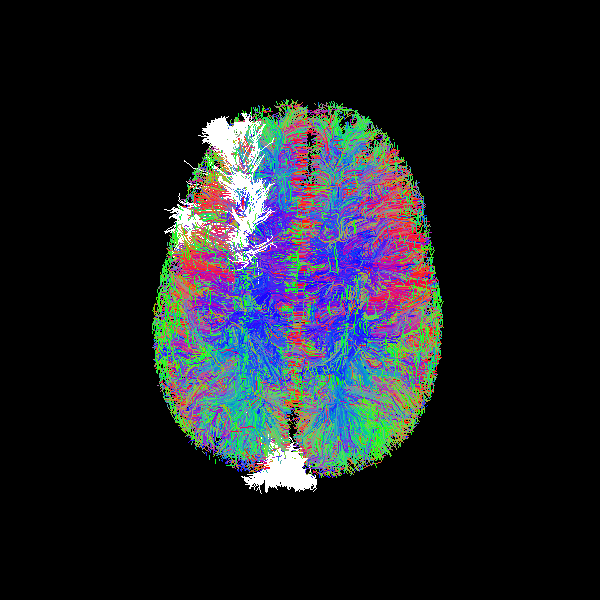

In [76]:
renpath=os.path.join(putdir, 'WB_IFOF_L.png')
genren(wb_rawprisma_sls[::100], t_tg_ifof.streamlines, putpath=renpath)
Image(renpath, width=400, height=400)

After

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


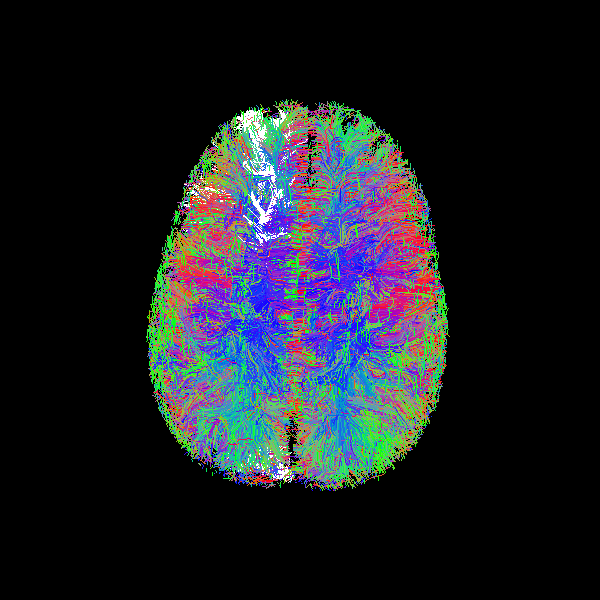

In [210]:
renpath=os.path.join(putdir, 'WB_IFOF_L.png')
genren(wb_rawprisma_sls[::100], t_sls_ifof_prisma, putpath=renpath)
Image(renpath, width=400, height=400)

## Check affine... I don't think it's off

In [ ]:
renpath=os.path.join(putdir, 'WB_IFOF_L_checkaff.png')
genren(, t_sls_ifof_prisma, putpath=renpath)
Image(renpath, width=400, height=400)

## Prisma IFOF

Find the template IFOF in the whole brain of another patient

In [212]:
rb_prisma_ifof_L, ig = run_rb(t_sls_ifof_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.009 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.308 sec. 

 Model bundle has 158 centroids
 Duration 0.318 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 10794
 Duration 1.192 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.161
 Number of iterations 51
 Matrix size (400, 600)
[[ 0.948 -0.03   0.005  1.112]
 [ 0.029  0.948  0.031  2.819]
 [-0.006 -0.031  0.948  3.963]
 [ 0.     0.     0.     1.   ]]
[ 0.034  3.233  0.181 -1.877  0.372  1.78   0.949]
 Duration 14.351 sec. 

# Prune streamlines using the MDF distance
 Prunin

#### Template IFOF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


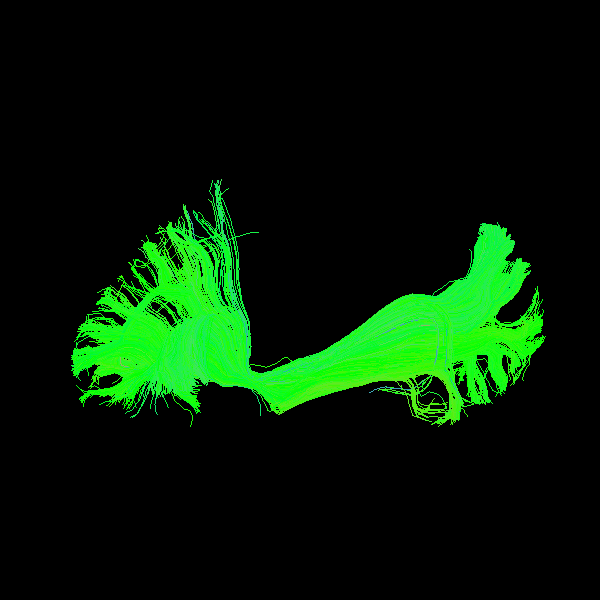

In [177]:
renpath2=os.path.join(putdir, 'template_IFOF_L.png')
genren(t_sls_ifof, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Interestingly, this worked with and without pre-registration

#### Recognized IFOF Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


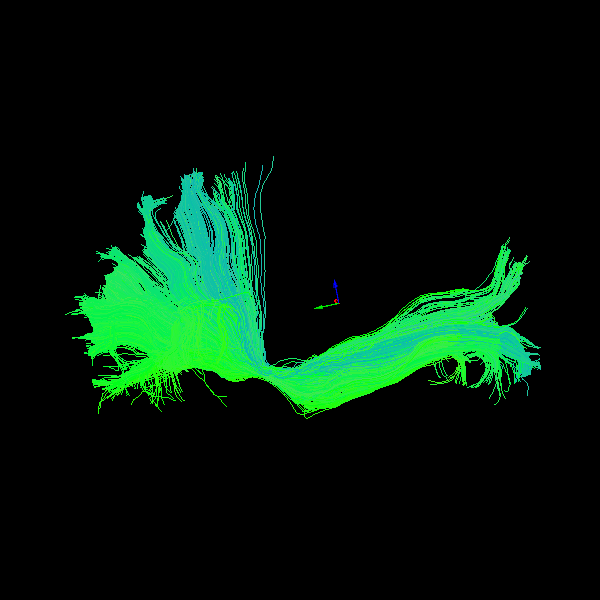

In [213]:
renpath=os.path.join(putdir, 'recognized_IFOF_L.png')
genren(rb_prisma_ifof_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## IFOF Trio

Test with a rescan of the same brain (different scanner/sequence)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


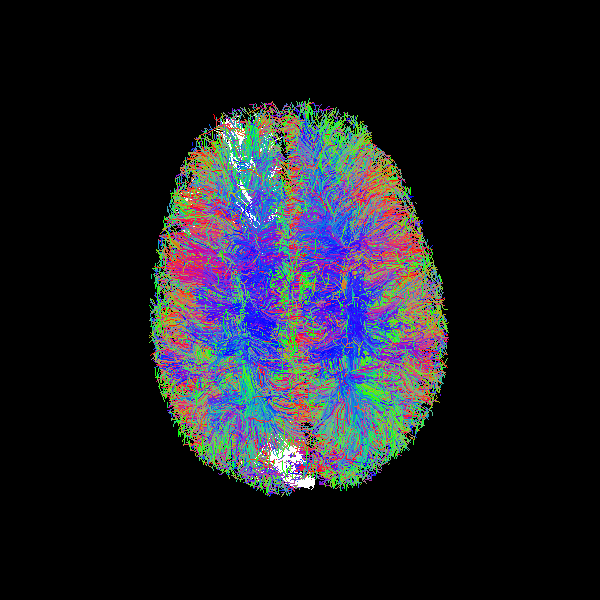

In [214]:
renpath=os.path.join(putdir, 'WB_IFOF_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_ifof_trio, putpath=renpath)
Image(renpath, width=400, height=400)

In [216]:
rb_rawtrio_ifof_L, ig = run_rb(t_sls_ifof_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.015 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.319 sec. 

 Model bundle has 143 centroids
 Duration 0.336 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 9683
 Duration 1.411 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 5.553
 Number of iterations 63
 Matrix size (400, 600)
[[ 0.971 -0.064  0.103  2.765]
 [ 0.054  0.973  0.093  0.81 ]
 [-0.108 -0.086  0.969 -2.392]
 [ 0.     0.     0.     1.   ]]
[-0.666  1.013 -4.588 -5.088  6.36   3.171  0.979]
 Duration 17.169 sec. 

# Prune streamlines using the MDF distance
 Pruning

#### Template IFOF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


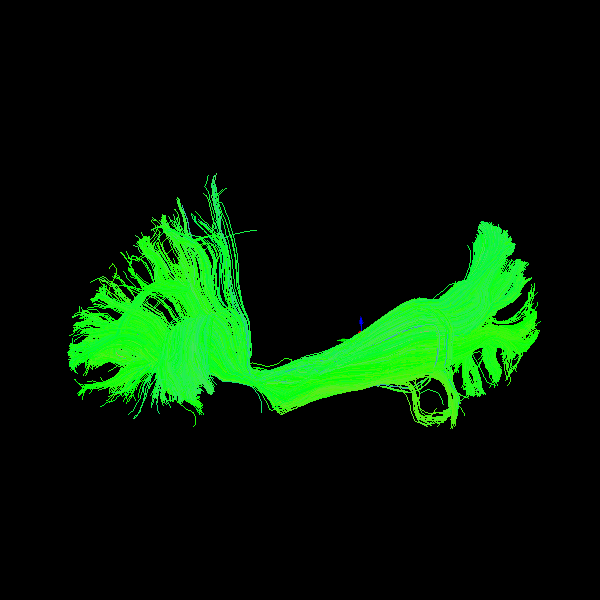

In [217]:
renpath2=os.path.join(putdir, 'template_IFOF_L.png')
genren(t_sls_ifof, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized IFOF Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


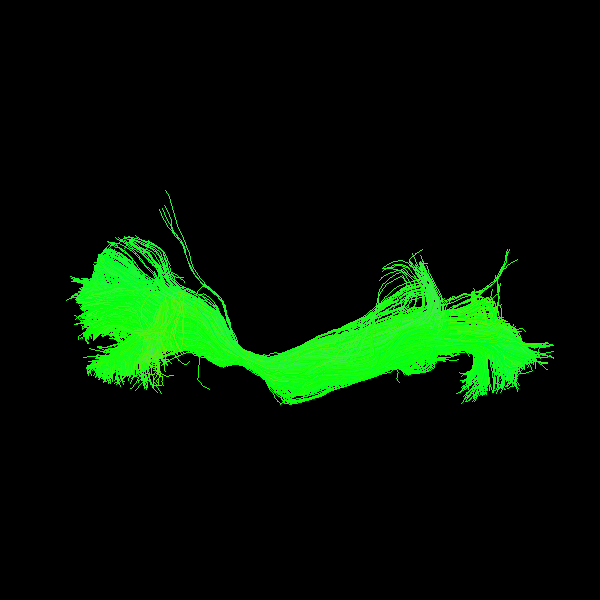

In [218]:
renpath=os.path.join(putdir, 'recognized_IFOF_L_RAW_TRIO.png')
genren(rb_rawtrio_ifof_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

This one failed without preregistration.. With preregistration, however, it works quite well

# ILF

In [219]:
template_ilf = os.path.join(template_basepath, 'ILF_L.trk')

t_tg_ilf = loadtgm_newapi(template_ilf)

t_sls_ilf_prisma = t_tg_ilf.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_ilf_trio = t_tg_ilf.copy().apply_affine(xfm_temp2trio).streamlines

## ILF Prisma

In [220]:
rb_prisma_ilf_L, ig = run_rb(t_sls_ilf_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 3289 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.753 MB
 Duration of resampling is 0.005 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.149 sec. 

 Model bundle has 84 centroids
 Duration 0.155 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 13080
 Duration 1.032 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.824
 Number of iterations 81
 Matrix size (400, 600)
[[  0.798   0.065   0.15   -2.238]
 [ -0.051   0.809  -0.079   6.155]
 [ -0.156   0.068   0.797 -10.967]
 [  0.      0.      0.      1.   ]]
[ 1.805  2.495  2.169  4.887 11.015 -3.652  0.815]
 Duration 21.208 sec. 

# Prune streamlines using the MDF d

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


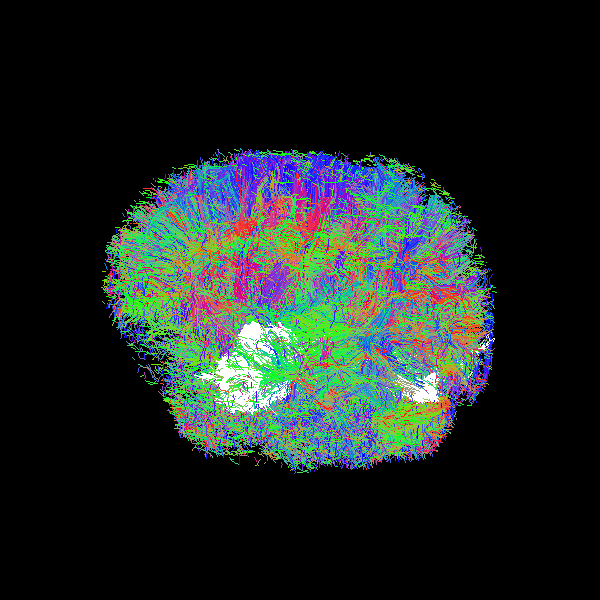

In [221]:
renpath=os.path.join(putdir, 'WB_ILF_L.png')
genren(wb_rawprisma_sls[::100], t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template ILF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


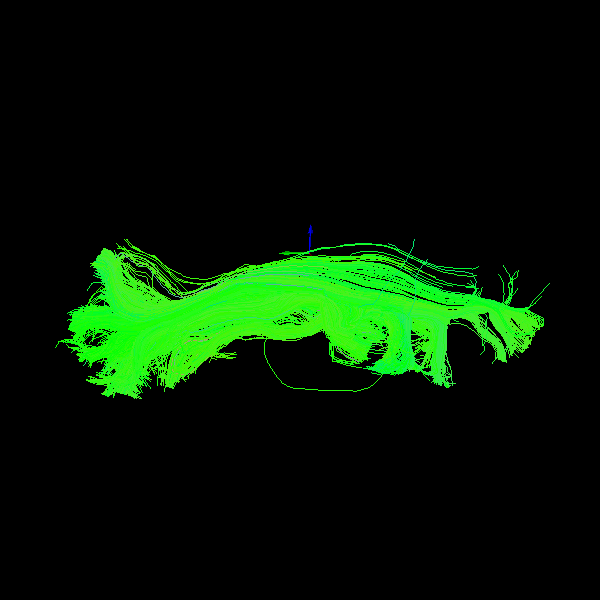

In [222]:
renpath=os.path.join(putdir, 'template_ILF_L.png')
genren(t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized ILF Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


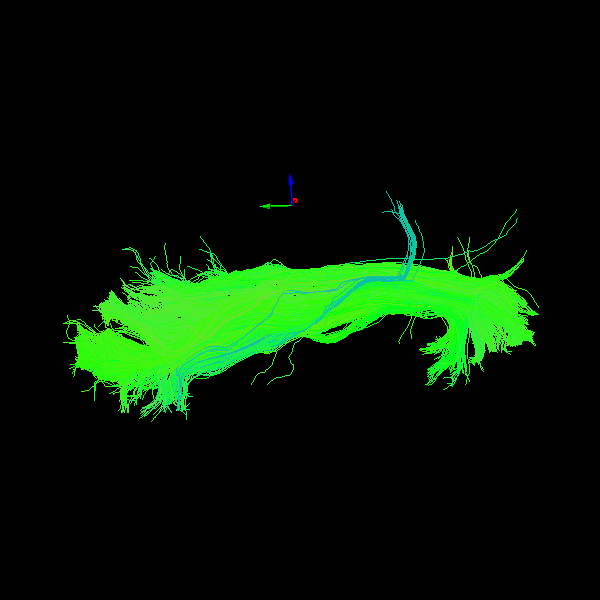

In [223]:
renpath=os.path.join(putdir, 'recognized_ILF_L.png')
genren(rb_prisma_ilf_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## ILF Trio

In [224]:
rb_trio_ilf_L, ig = run_rb(t_sls_ilf_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 3289 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.753 MB
 Duration of resampling is 0.005 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.149 sec. 

 Model bundle has 80 centroids
 Duration 0.155 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 9044
 Duration 1.006 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.376
 Number of iterations 65
 Matrix size (400, 600)
[[ 0.92   0.028  0.146  0.009]
 [-0.02   0.931 -0.053  1.832]
 [-0.147  0.049  0.919 -3.711]
 [ 0.     0.     0.     1.   ]]
[ 1.859  0.122  3.447  3.068  9.102 -1.264  0.932]
 Duration 19.946 sec. 

# Prune streamlines using the MDF distance
 Pruning 

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


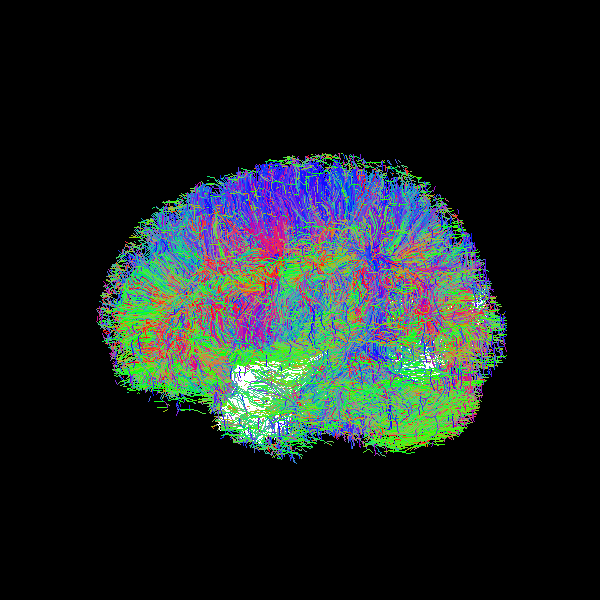

In [225]:
renpath=os.path.join(putdir, 'WB_ILF_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_ilf_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template ILF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


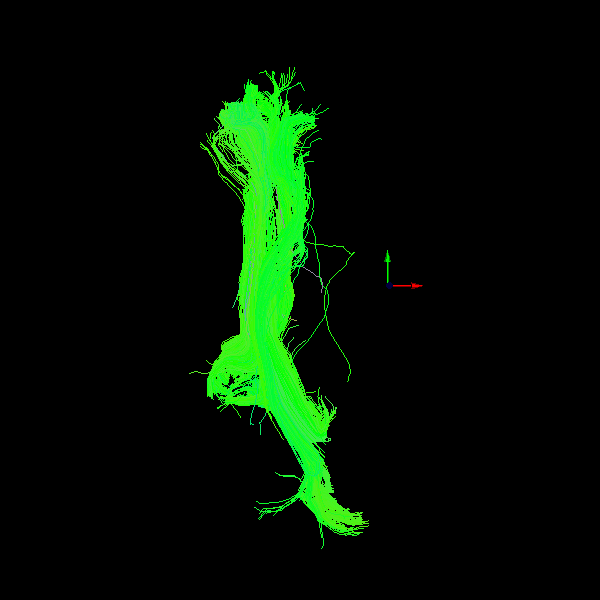

In [226]:
renpath=os.path.join(putdir, 'template_ILF_L.png')
genren(t_sls_ilf, putpath=renpath)
Image(renpath, width=400, height=400)

#### Recognized ILF Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


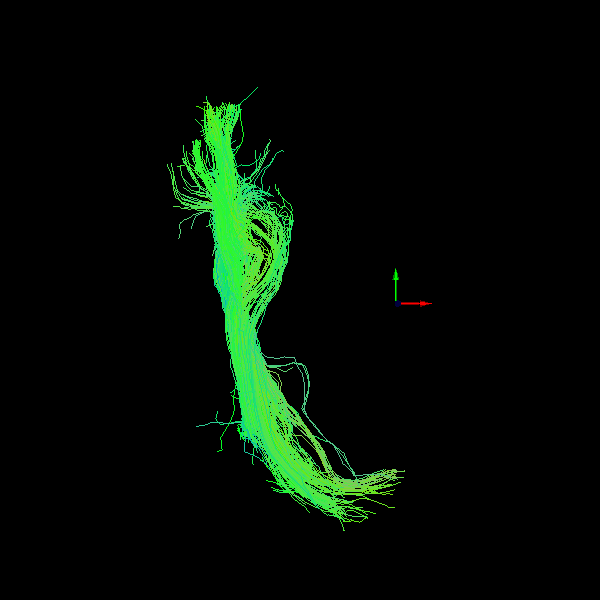

In [227]:
renpath=os.path.join(putdir, 'recognized_ILF_L_TRIO.png')
genren(rb_trio_ilf_L, putpath=renpath)
Image(renpath, width=400, height=400)

# Uncinate

In [228]:
template_unc = os.path.join(template_basepath, 'Uncinate_L.trk')

t_tg_unc = loadtgm_newapi(template_unc)
t_sls_unc_prisma = t_tg_unc.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_unc_trio = t_tg_unc.copy().apply_affine(xfm_temp2trio).streamlines

## Uncinate Prisma

In [229]:
rb_prisma_unc_L,ig = run_rb(t_sls_unc_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 878 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.201 MB
 Duration of resampling is 0.002 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.032 sec. 

 Model bundle has 32 centroids
 Duration 0.034 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 17605
 Duration 0.640 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.725
 Number of iterations 51
 Matrix size (400, 600)
[[ 0.791 -0.111  0.036 -1.467]
 [ 0.116  0.776 -0.156  9.848]
 [-0.013  0.159  0.784 -4.694]
 [ 0.     0.     0.     1.   ]]
[-2.935 -6.29  -0.668 11.492  0.959  8.355  0.8  ]
 Duration 14.036 sec. 

# Prune streamlines using the MDF distance
 Pruning 

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


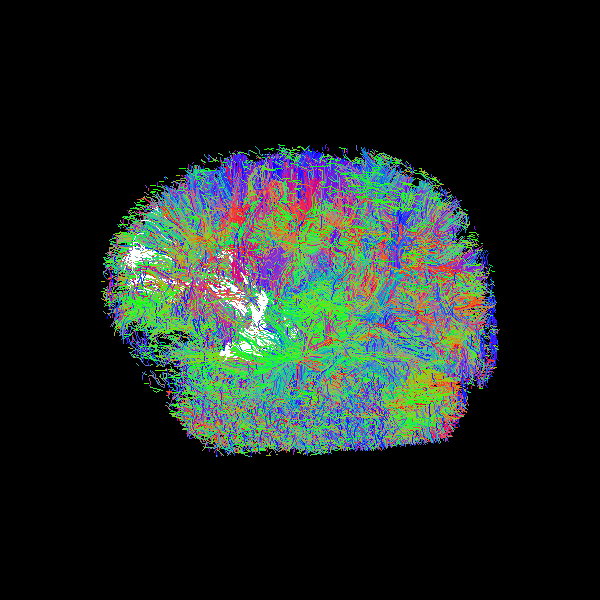

In [230]:
renpath=os.path.join(putdir, 'WB_UNC_L.png')
genren(wb_rawprisma_sls[::100], t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Uncinate Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


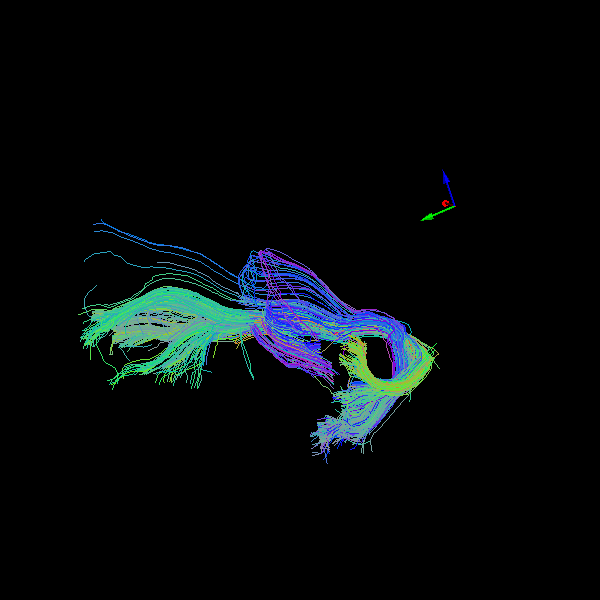

In [231]:
renpath=os.path.join(putdir, 'template_UNC_L.png')
genren(t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Uncinate Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


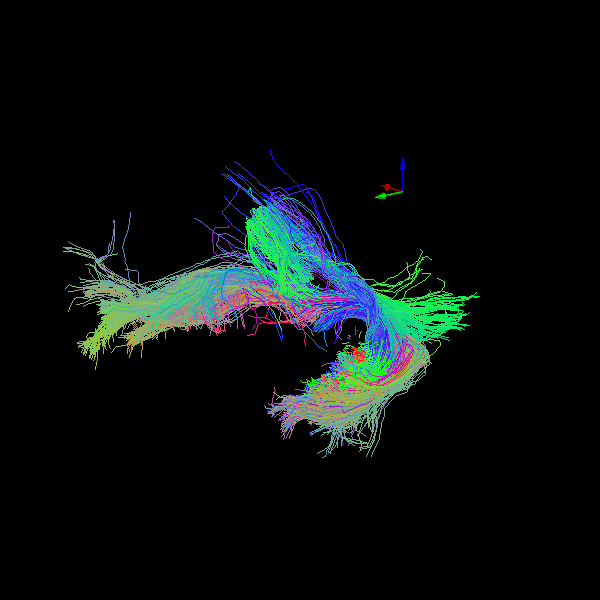

In [232]:
renpath=os.path.join(putdir, 'recognized_UNC_L.png')
genren(rb_prisma_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Trio Uncinate

In [233]:
rb_trio_unc_L, ig = run_rb(t_sls_unc_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 878 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.201 MB
 Duration of resampling is 0.002 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.033 sec. 

 Model bundle has 30 centroids
 Duration 0.036 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 12345
 Duration 0.538 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.243
 Number of iterations 33
 Matrix size (400, 600)
[[ 0.779 -0.152  0.103 -0.489]
 [ 0.162  0.78  -0.071 18.676]
 [-0.087  0.09   0.79  -3.552]
 [ 0.     0.     0.     1.   ]]
[-2.048 -6.811 -1.279  6.478  6.245 11.749  0.8  ]
 Duration 8.308 sec. 

# Prune streamlines using the MDF distance
 Pruning t

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


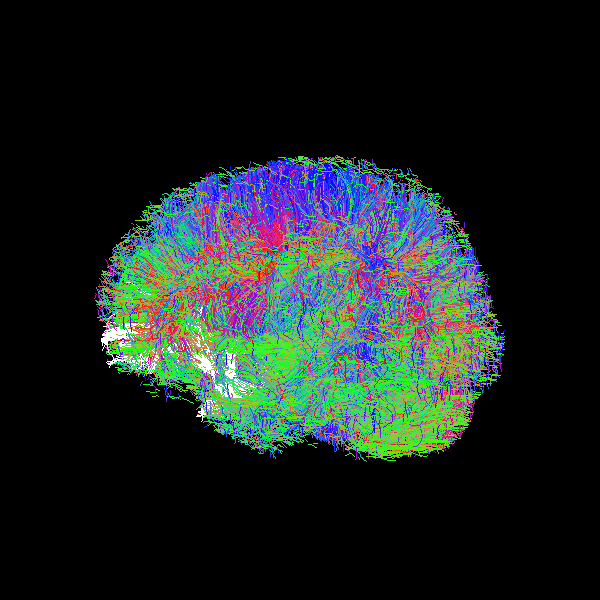

In [234]:
renpath=os.path.join(putdir, 'WB_UNC_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_unc_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template Uncinate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


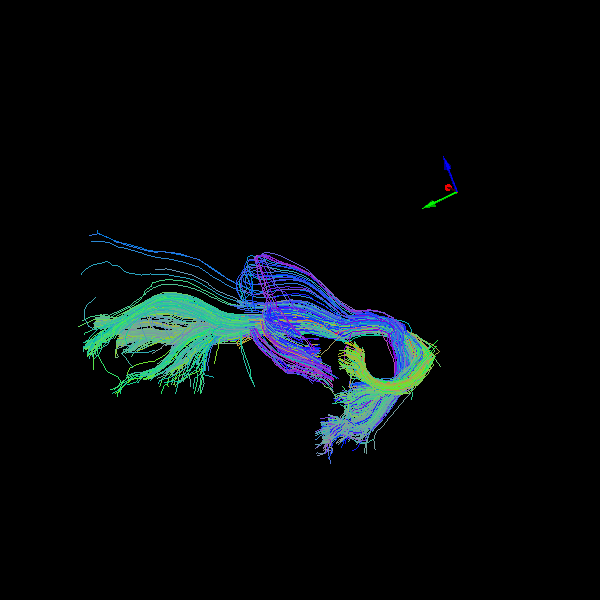

In [235]:
renpath=os.path.join(putdir, 'template_UNC_L.png')
genren(t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Uncinate Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


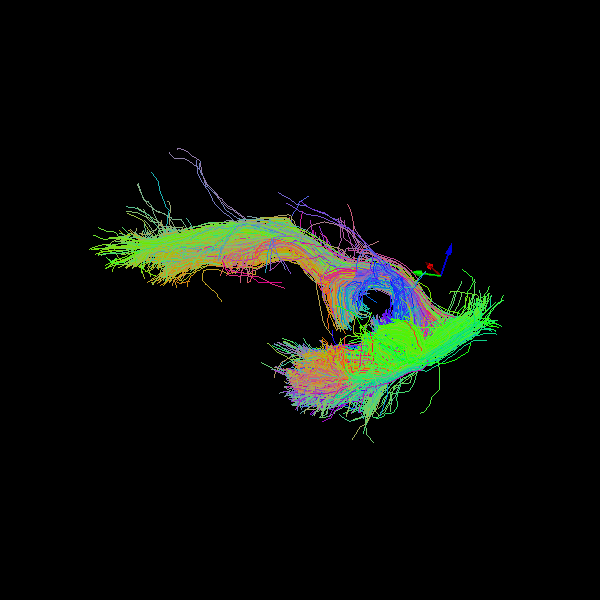

In [236]:
renpath=os.path.join(putdir, 'recognized_UNC_L_TRIO.png')
genren(rb_trio_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# Aslant

In [237]:
template_aslant = os.path.join(template_basepath, 'Aslant_L.trk')

t_tg_aslant = loadtgm_newapi(template_aslant)
t_sls_aslant_prisma = t_tg_aslant.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_aslant_trio = t_tg_aslant.copy().apply_affine(xfm_temp2trio).streamlines

## Prisma Aslant

In [238]:
rb_prisma_aslant_L, ig = run_rb(t_sls_aslant_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 1792 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.410 MB
 Duration of resampling is 0.004 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.050 sec. 

 Model bundle has 18 centroids
 Duration 0.055 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 10394
 Duration 0.507 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 4.102
 Number of iterations 42
 Matrix size (400, 600)
[[ 0.938 -0.025  0.011 -2.797]
 [ 0.025  0.938  0.    -0.745]
 [-0.011 -0.     0.938  3.174]
 [ 0.     0.     0.     1.   ]]
[ 2.682 -0.928  1.029 -0.004  0.658  1.544  0.938]
 Duration 12.360 sec. 

# Prune streamlines using the MDF distance
 Pruning

#### Aslant Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


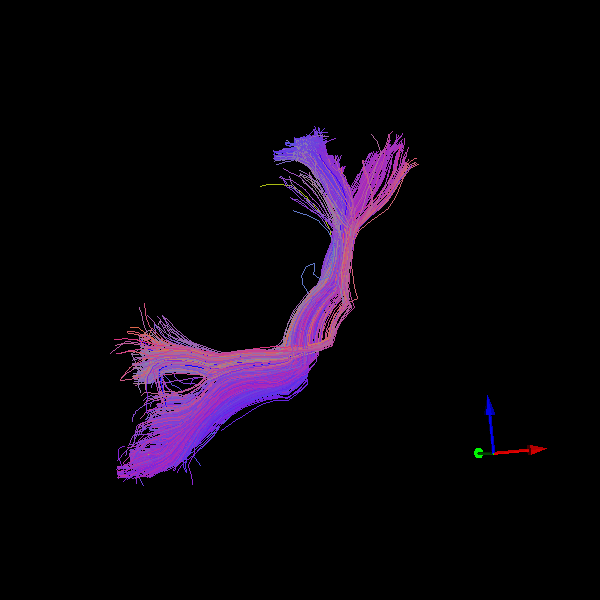

In [239]:
renpath=os.path.join(putdir, 'template_Aslant_L.png')
genren(t_sls_aslant_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Aslant Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


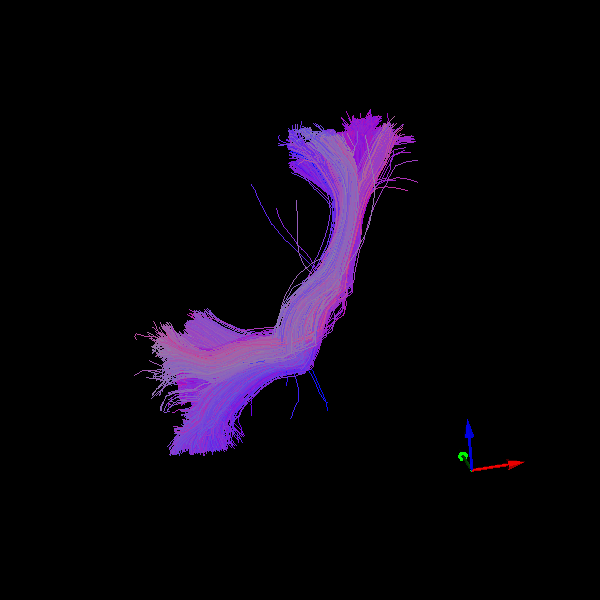

In [240]:
renpath=os.path.join(putdir, 'recognized_Aslant_L.png')
genren(rb_prisma_aslant_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Aslant Prisma

In [241]:
gold=glob(os.path.join(gs_prisma_path, 'Aslant_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


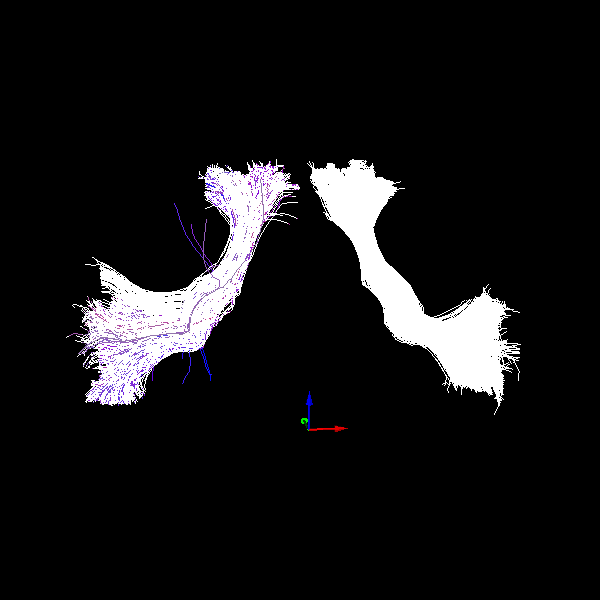

In [242]:
renpath=os.path.join(putdir, 'gold_Aslant_L_PRISMA_WHOLEBRAIN.png')
genren(rb_prisma_aslant_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Trio Aslant

In [243]:
rb_trio_aslant_L, ig = run_rb(t_sls_aslant_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 1792 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.410 MB
 Duration of resampling is 0.005 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.050 sec. 

 Model bundle has 16 centroids
 Duration 0.055 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 5188
 Duration 0.291 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 2.700
 Number of iterations 54
 Matrix size (400, 600)
[[ 0.956  0.034 -0.021 -0.332]
 [-0.036  0.952 -0.083  1.047]
 [ 0.018  0.084  0.953 -3.995]
 [ 0.     0.     0.     1.   ]]
[ 0.955  0.493 -0.107  5.015 -1.091 -2.162  0.956]
 Duration 15.508 sec. 

# Prune streamlines using the MDF distance
 Pruning 

#### Template Aslant

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


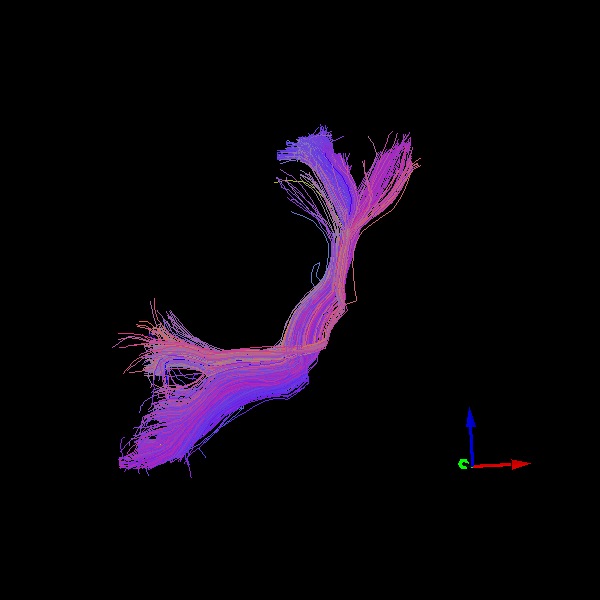

In [244]:
renpath=os.path.join(putdir, 'template_Aslant_L.png')
genren(t_sls_aslant_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Aslant Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


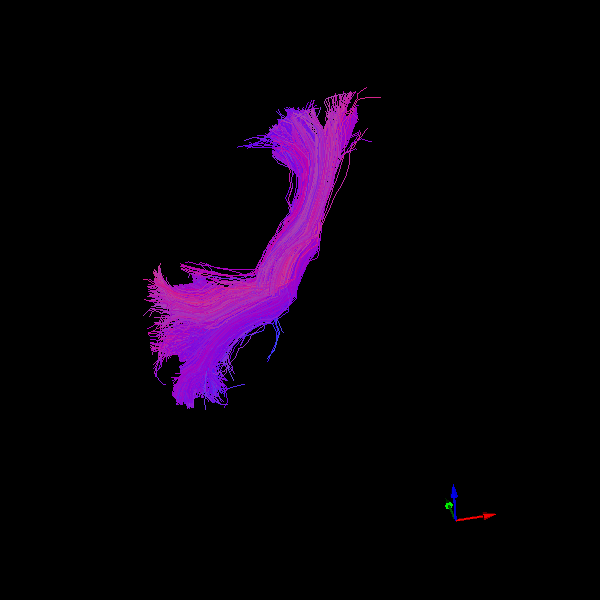

In [245]:
renpath=os.path.join(putdir, 'recognized_Aslant_L_TRIO.png')
genren(rb_trio_aslant_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Aslant Trio

In [246]:
gold=glob(os.path.join(gs_trio_path, 'Aslant_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


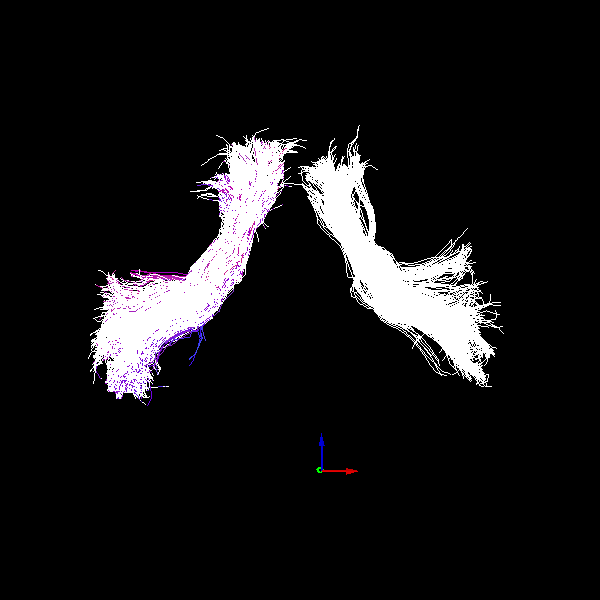

In [247]:
renpath=os.path.join(putdir, 'gold_Aslant_L_TRIO_WHOLEBRAIN.png')
genren(rb_trio_aslant_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# Arcuate

In [248]:
template_arcuate = os.path.join(template_basepath, 'Arcuate_L.trk')

t_tg_arcuate = loadtgm_newapi(template_arcuate)
t_sls_arcuate_prisma = t_tg_arcuate.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_arcuate_trio = t_tg_arcuate.copy().apply_affine(xfm_temp2trio).streamlines

## Arcuate Prisma

In [249]:
rb_prisma_arcuate_L, ig = run_rb(t_sls_arcuate_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 19566 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 4.478 MB
 Duration of resampling is 0.026 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.969 sec. 

 Model bundle has 309 centroids
 Duration 0.995 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 15737
 Duration 2.502 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.003
 Number of iterations 53
 Matrix size (400, 600)
[[ 1.062 -0.017  0.011  2.808]
 [ 0.018  1.056 -0.116  2.096]
 [-0.009  0.116  1.056 -2.815]
 [ 0.     0.     0.     1.   ]]
[-1.388 -2.295  0.351  6.285  0.475  0.977  1.062]
 Duration 14.960 sec. 

# Prune streamlines using the MDF distance
 Pruni

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


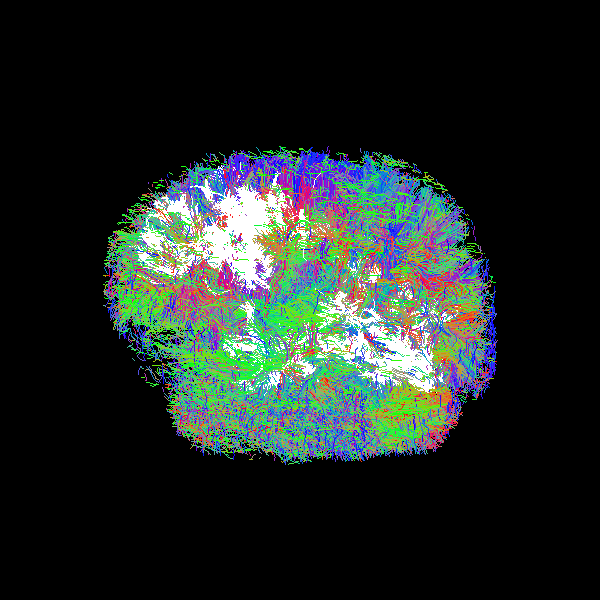

In [250]:
renpath=os.path.join(putdir, 'WB_Arcuate_L.png')
genren(wb_rawprisma_sls[::100], t_sls_arcuate_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template Arcuate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


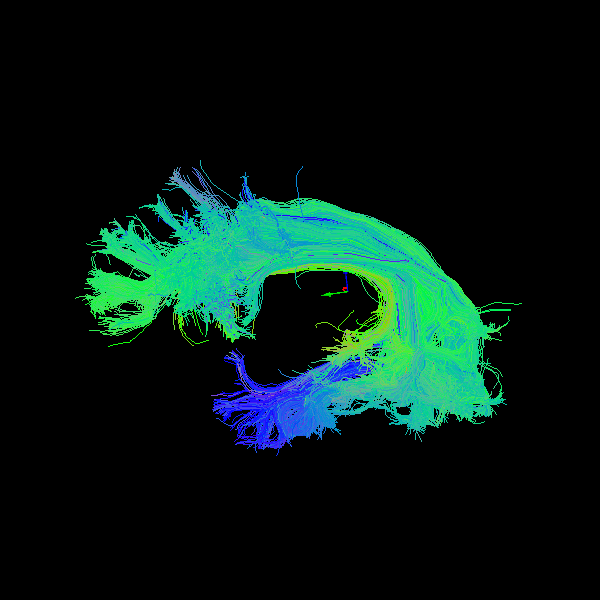

In [251]:
renpath=os.path.join(putdir, 'template_Arcuate_L.png')
genren(t_sls_arcuate_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Arcuate Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


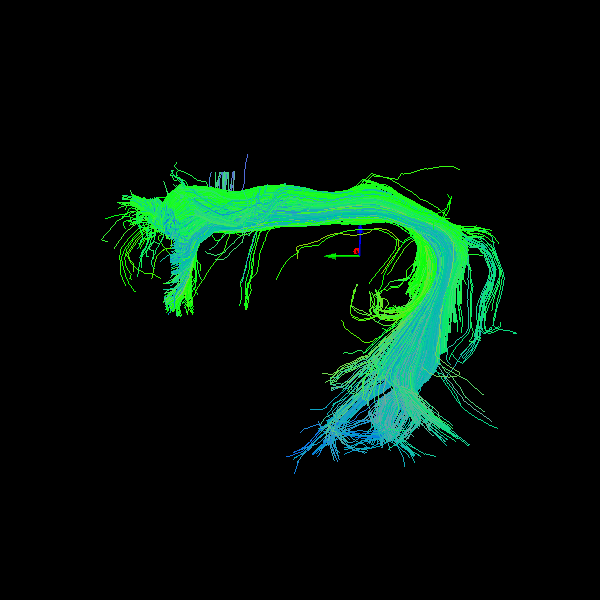

In [252]:
renpath=os.path.join(putdir, 'recognized_Arcuate_L.png')
genren(rb_prisma_arcuate_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Arcuate Prisma

In [253]:
gold=glob(os.path.join(gs_prisma_path, 'Arcuate_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


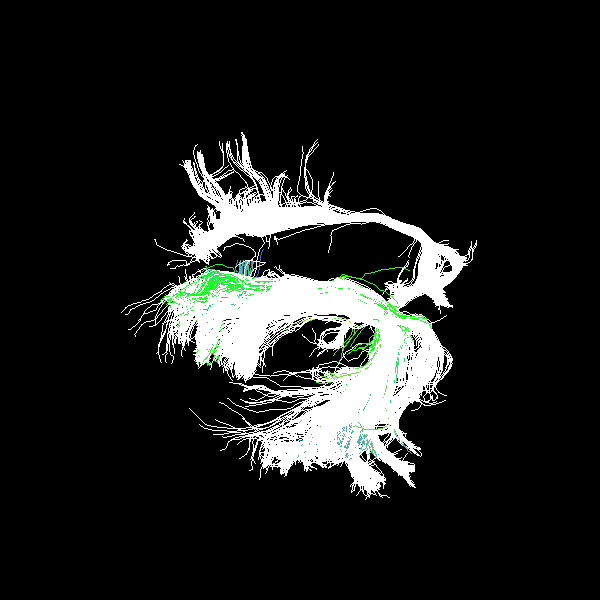

In [254]:
renpath=os.path.join(putdir, 'gold_Arcuate_L.png')
genren(rb_prisma_arcuate_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Arcuate Trio

In [255]:
rb_trio_arcuate_L, ig = run_rb(t_sls_arcuate_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 19566 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 4.478 MB
 Duration of resampling is 0.029 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.873 sec. 

 Model bundle has 286 centroids
 Duration 0.902 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 12881
 Duration 2.717 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 9.760
 Number of iterations 51
 Matrix size (400, 600)
[[ 1.029 -0.018 -0.021  5.935]
 [ 0.018  1.029  0.025  3.087]
 [ 0.021 -0.026  1.029 -4.51 ]
 [ 0.     0.     0.     1.   ]]
[-1.494  0.256 -0.363 -1.433 -1.155  1.012  1.029]
 Duration 14.343 sec. 

# Prune streamlines using the MDF distance
 Pruni

#### Template Arcuate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


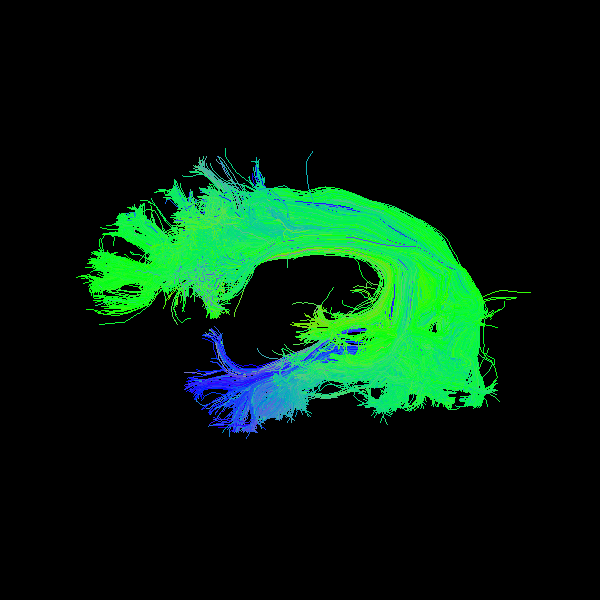

In [256]:
renpath=os.path.join(putdir, 'template_Arcuate_L_TRIO.png')
genren(t_sls_arcuate_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Arcuate Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


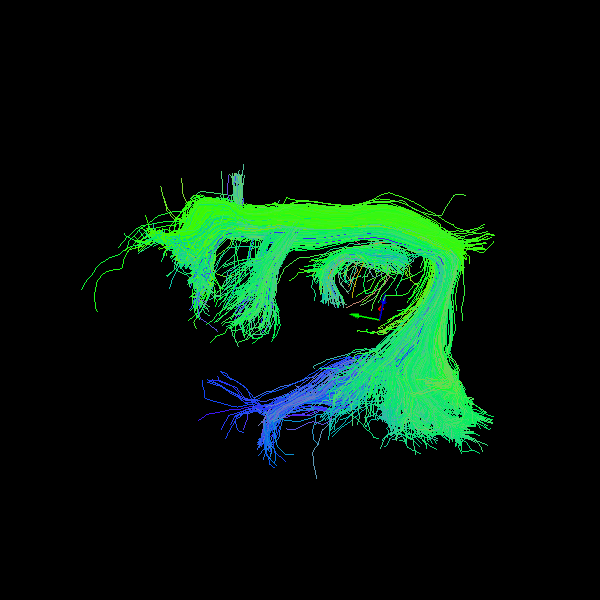

In [257]:
renpath=os.path.join(putdir, 'recognized_Arcuate_L.png')
genren(rb_trio_arcuate_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# SLF-IP

In [258]:
template_ip = os.path.join(template_basepath, 'SLF_IP_L.trk')

t_tg_slfip = loadtgm_newapi(template_ip)
t_sls_slfip_prisma = t_tg_slfip.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_slfip_trio = t_tg_slfip.copy().apply_affine(xfm_temp2trio).streamlines

## SLF-IP Prisma

In [259]:
rb_prisma_slfip_L, ig = run_rb(t_sls_slfip_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 9201 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 2.106 MB
 Duration of resampling is 0.012 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.406 sec. 

 Model bundle has 169 centroids
 Duration 0.419 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 25537
 Duration 1.552 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.801
 Number of iterations 62
 Matrix size (400, 600)
[[ 0.91  -0.013  0.106 -3.92 ]
 [ 0.039  0.889 -0.218  0.959]
 [-0.1    0.221  0.883 -1.727]
 [ 0.     0.     0.     1.   ]]
[-5.04   4.381 -2.189 14.075  6.271  2.432  0.916]
 Duration 17.166 sec. 

# Prune streamlines using the MDF distance
 Prunin

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


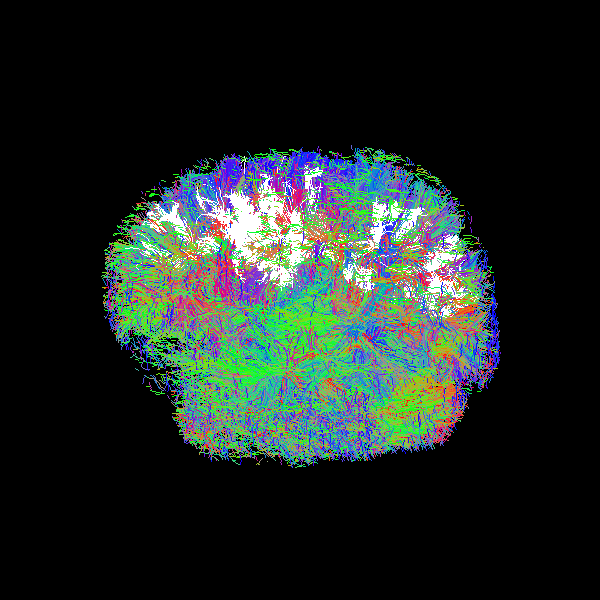

In [260]:
renpath=os.path.join(putdir, 'WB_SLFIP_L.png')
genren(wb_rawprisma_sls[::100], t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### SLF-IP Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


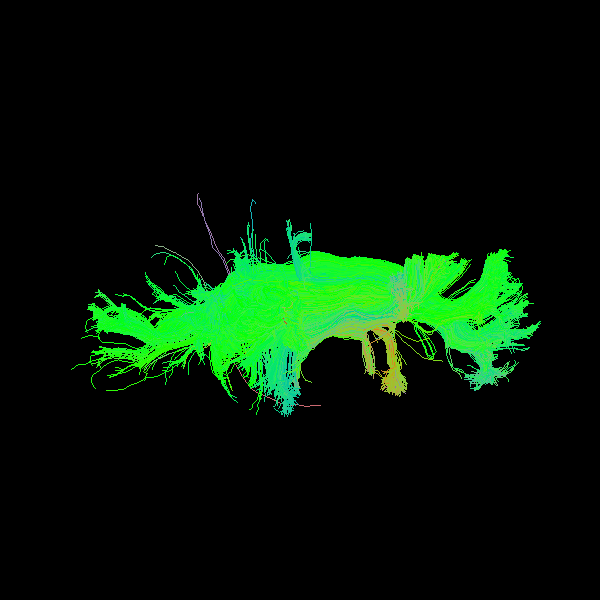

In [261]:
renpath=os.path.join(putdir, 'template_SLFIP_L.png')
genren(t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


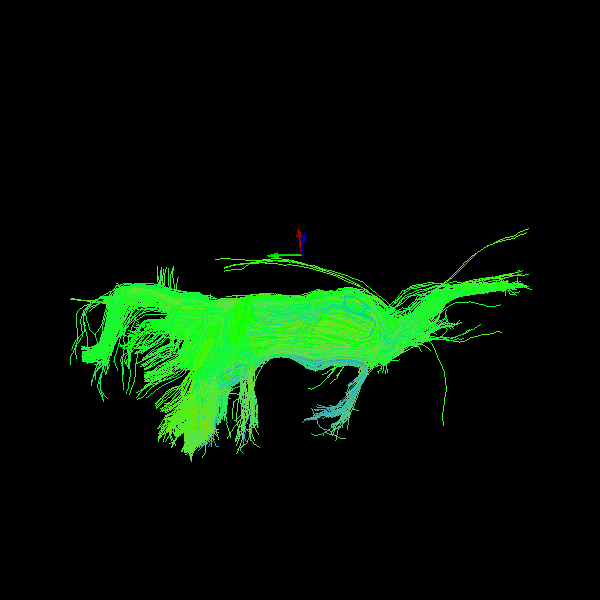

In [262]:
renpath=os.path.join(putdir, 'recognized_SLFIP_L.png')
genren(rb_prisma_slfip_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

There is a little extra truncated Arcuate included in this SLF-IP model

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


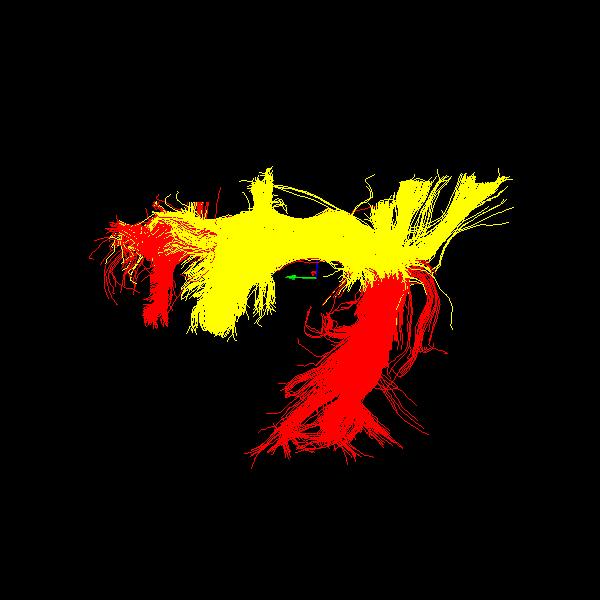

In [265]:
renpath=os.path.join(putdir, 'Arcuate_vs_SLFIP_L.png')
genren(rb_prisma_arcuate_L, rb_prisma_slfip_L, putpath=renpath, show=True, colors=[(1,1,0),(1,0,0)])
Image(renpath, width=400, height=400)

## SLF-IP Trio

In [264]:
rb_trio_slfip_L, ig = run_rb(t_sls_slfip_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 9201 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 2.106 MB
 Duration of resampling is 0.011 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.397 sec. 

 Model bundle has 156 centroids
 Duration 0.409 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 15747
 Duration 1.832 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.299
 Number of iterations 71
 Matrix size (400, 600)
[[  0.941   0.036   0.274 -11.953]
 [  0.003   0.971  -0.139   5.223]
 [ -0.277   0.134   0.931 -10.353]
 [  0.      0.      0.      1.   ]]
[-4.237  4.922 -4.163  8.218 16.4    0.187  0.98 ]
 Duration 22.046 sec. 

# Prune streamlines using the MDF 

#### SLF-IP Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


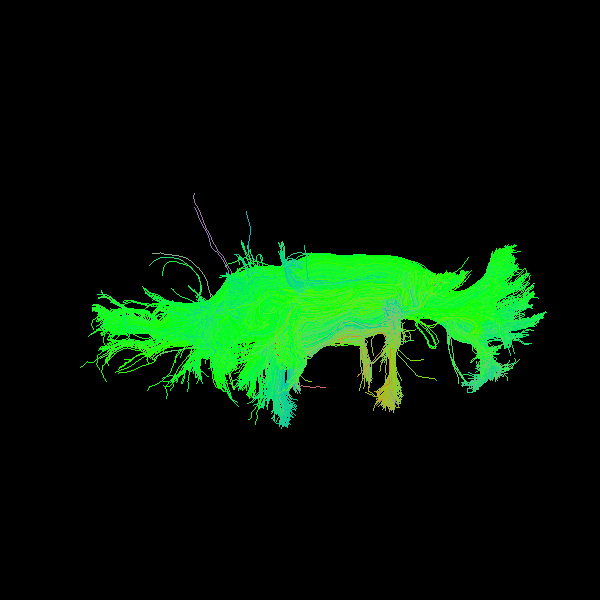

In [266]:
renpath=os.path.join(putdir, 'template_SLFIP_L.png')
genren(t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### SLF-IP Recognized Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


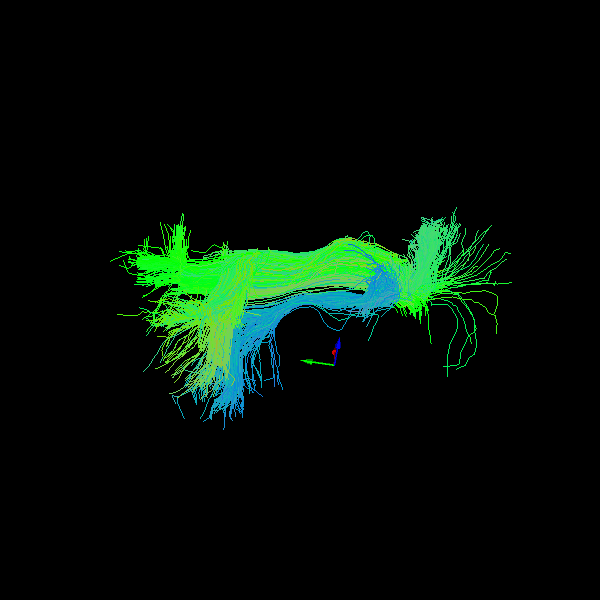

In [267]:
renpath=os.path.join(putdir, 'recognized_SLFIP_L_TRIO.png')
genren(rb_trio_slfip_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# SLF-tp

In [268]:
template_tp = os.path.join(template_basepath, 'SLF-tp_L.trk')
t_tg_slftp = loadtgm_newapi(template_tp)
t_sls_slftp_prisma = t_tg_slftp.copy().apply_affine(xfm_temp2prisma).streamlines
t_sls_slftp_trio = t_tg_slftp.copy().apply_affine(xfm_temp2trio).streamlines

## SLF-tp Prisma

In [269]:
rb_prisma_slftp_L, ig = run_rb(t_sls_slftp_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 2226 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.509 MB
 Duration of resampling is 0.006 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.061 sec. 

 Model bundle has 29 centroids
 Duration 0.068 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 21421
 Duration 0.661 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.504
 Number of iterations 43
 Matrix size (400, 600)
[[  0.774  -0.181   0.09  -12.077]
 [  0.185   0.778  -0.019   3.798]
 [ -0.084   0.039   0.795  -3.245]
 [  0.      0.      0.      1.   ]]
[ 0.674 -3.202 -0.671  2.802  5.999 13.412  0.8  ]
 Duration 11.469 sec. 

# Prune streamlines using the MDF d

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


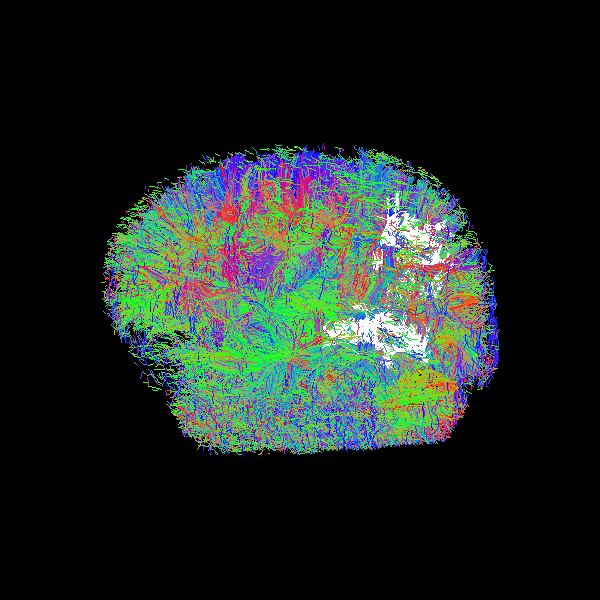

In [270]:
renpath=os.path.join(putdir, 'WB_SLFTP_L.png')
genren(wb_rawprisma_sls[::100], t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template SLF-tp

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


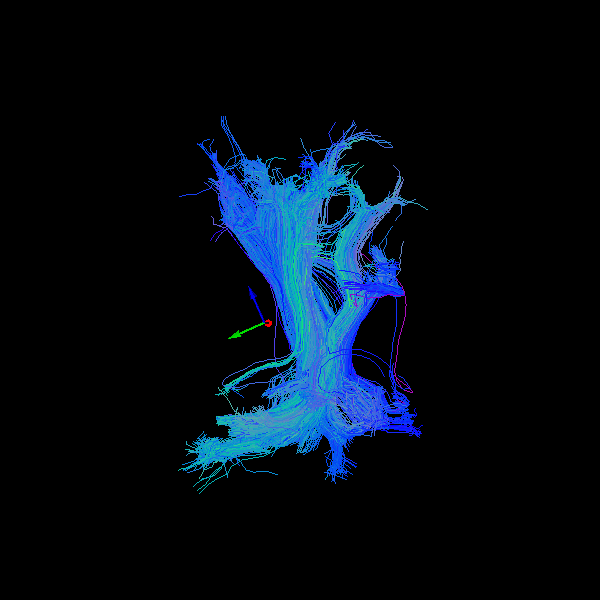

In [271]:
renpath=os.path.join(putdir, 'template_SLFTP_L.png')
genren(t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized SLF-tp Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


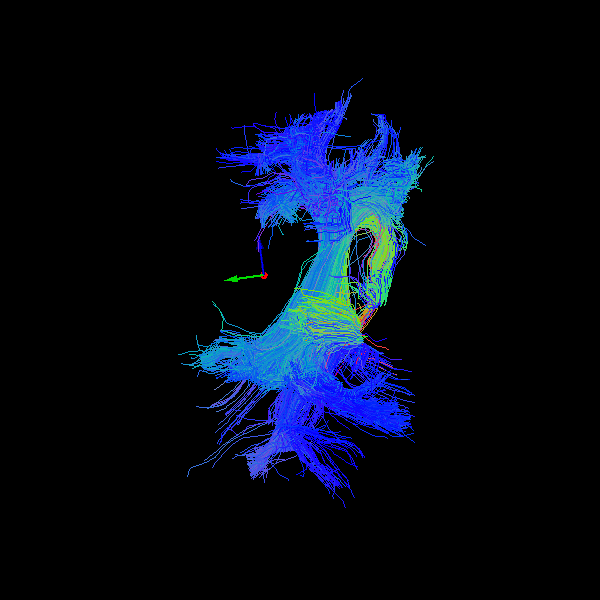

In [272]:
renpath=os.path.join(putdir, 'recognized_SLFTP_L.png')
genren(rb_prisma_slftp_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


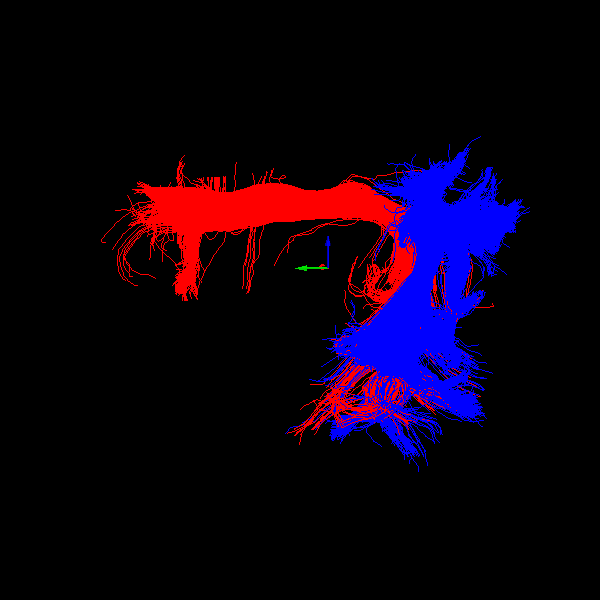

In [273]:
renpath=os.path.join(putdir, 'Arcuate_vs_SLFTP_L.png')
genren(rb_prisma_arcuate_L, rb_prisma_slftp_L, putpath=renpath, show=True, colors=[(0,0,1),(1,0,0)])
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


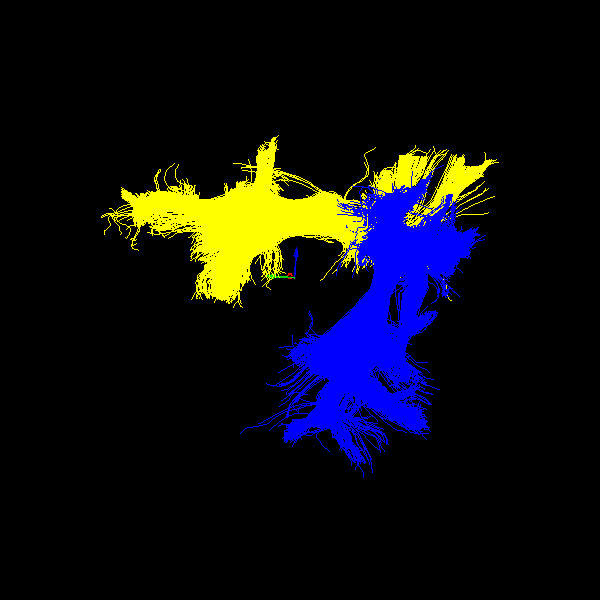

In [274]:
renpath=os.path.join(putdir, 'SLFIP_vs_SLFTP_L.png')
genren(rb_prisma_slfip_L, rb_prisma_slftp_L, putpath=renpath, show=True, colors=[(0,0,1),(1,1,0)])
Image(renpath, width=400, height=400)

## SLF-tp Trio

In [275]:
rb_trio_slftp_L, ig = run_rb(t_sls_slftp_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 2226 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.509 MB
 Duration of resampling is 0.003 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.085 sec. 

 Model bundle has 29 centroids
 Duration 0.088 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 11943
 Duration 0.484 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.219
 Number of iterations 57
 Matrix size (400, 600)
[[ 0.804 -0.138  0.06  -7.594]
 [ 0.138  0.806  0.016  2.925]
 [-0.062 -0.005  0.816  2.761]
 [ 0.     0.     0.     1.   ]]
[ 2.176 -1.896  1.931 -0.37   4.342  9.709  0.818]
 Duration 16.309 sec. 

# Prune streamlines using the MDF distance
 Pruning

#### Template SLF-tp

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


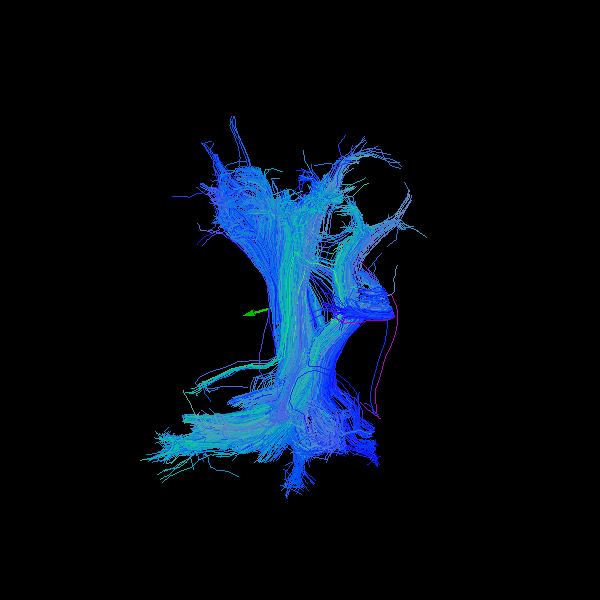

In [276]:
renpath=os.path.join(putdir, 'template_SLFTP_L.png')
genren(t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized SLF-tp Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


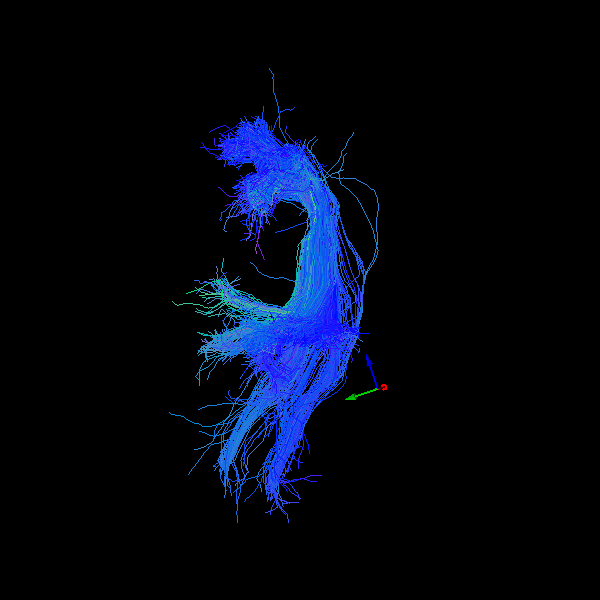

In [277]:
renpath=os.path.join(putdir, 'recognized_SLFTP_L_TRIO.png')
genren(rb_trio_slftp_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Notes:

- static = template; moving = patient (trio/prisma)

- Try pruning thresh = 5

- Improve template
    - bundle atlas online??
    - Frank Yeh? (link) N=100 bundles
    - CC one bundle
    - DSI studio

- Improve registration? 

- Try w/healthy datasets diffeo w/FA
    - PR by Conner for streamline handling
    https://github.com/nipy/dipy/pull/1398
    - DISABLE LOCAL SLR b/c bundles are on top of each other
    - for WM: the local registrations more accurate than global
    - Note: try DTI-TK and/or 
    
 - Now that you have a bundle extracted, it allows you to interactively expand
 
 - IIT
 
 - SLR re-register and reprune
    

Similarity Projection